In [30]:
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from typing import Optional

In [31]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

In [32]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./documentos/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [33]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

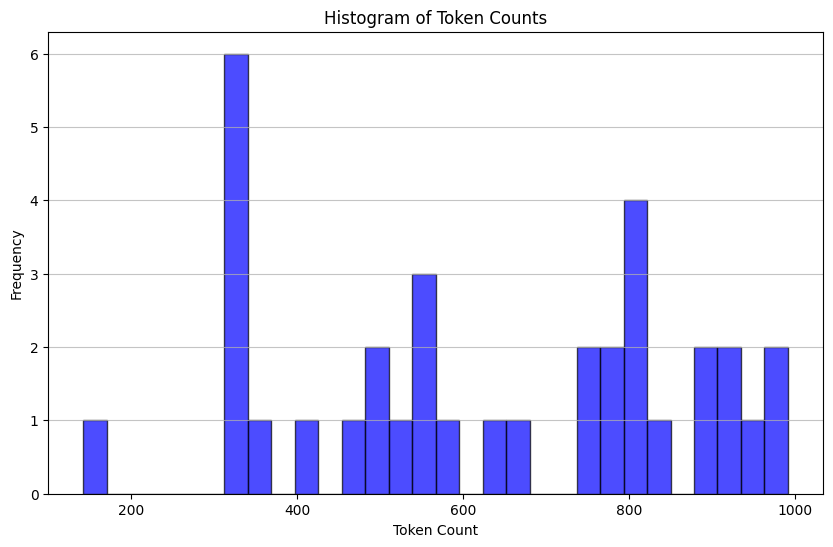

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [35]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 22157


# Se debe encontrar la manera de guardar los vectores de un embeding de manera local, para ahorrar en embeddings.

In [36]:
global_embeddings = [embeddings.embed_query(txt) for txt in texts]

In [37]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced

array([[10.294651 , 17.32026  ],
       [10.631482 , 14.660879 ],
       [11.066402 , 14.379072 ],
       [11.002208 , 17.46104  ],
       [10.752725 , 17.145983 ],
       [11.168399 , 16.44017  ],
       [10.888454 , 14.73083  ],
       [12.956274 , 15.7746525],
       [11.584635 , 17.544779 ],
       [12.620641 , 17.841024 ],
       [12.123714 , 16.401617 ],
       [12.451246 , 17.127146 ],
       [12.112635 , 17.69216  ],
       [12.319588 , 17.437685 ],
       [11.937442 , 15.41502  ],
       [12.705479 , 15.335839 ],
       [11.62086  , 18.176886 ],
       [12.478314 , 15.550007 ],
       [10.99431  , 15.7188425],
       [12.546862 , 17.788582 ],
       [11.132306 , 17.972046 ],
       [11.369623 , 14.922296 ],
       [12.967179 , 15.328294 ],
       [10.240668 , 17.705229 ],
       [ 8.442447 , 16.303669 ],
       [ 9.4622965, 15.655144 ],
       [ 8.4969015, 16.762022 ],
       [ 8.977148 , 16.644308 ],
       [ 8.647572 , 16.123652 ],
       [10.084752 , 15.1861105],
       [ 8

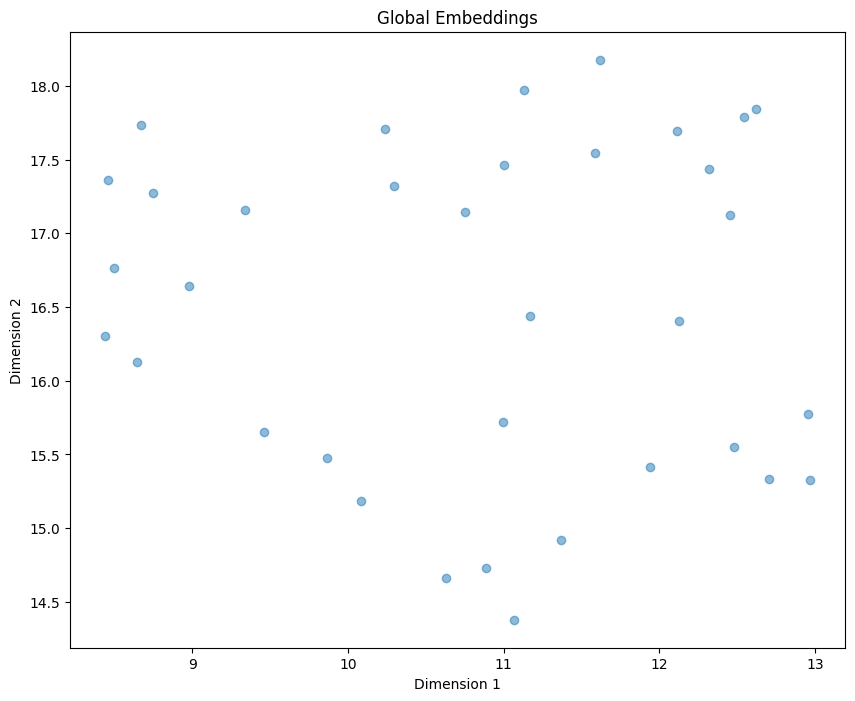

In [38]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

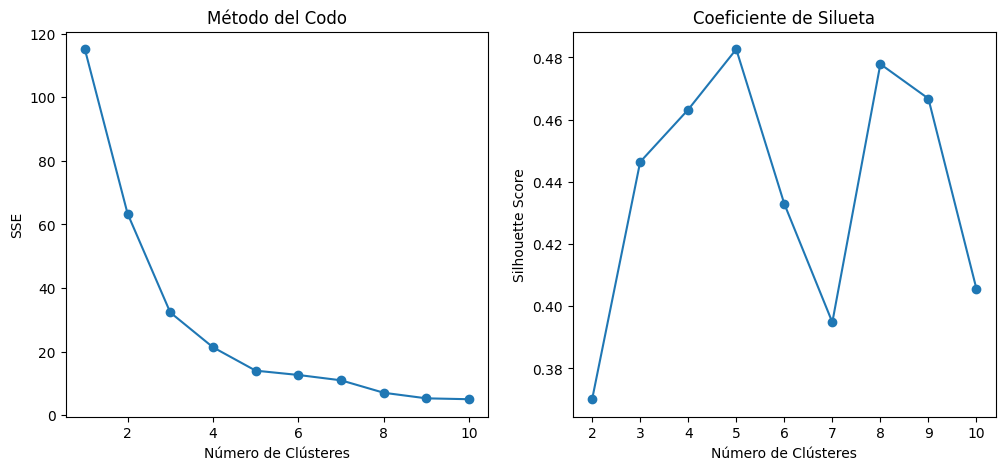

In [39]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Silhouette Score')

plt.show()

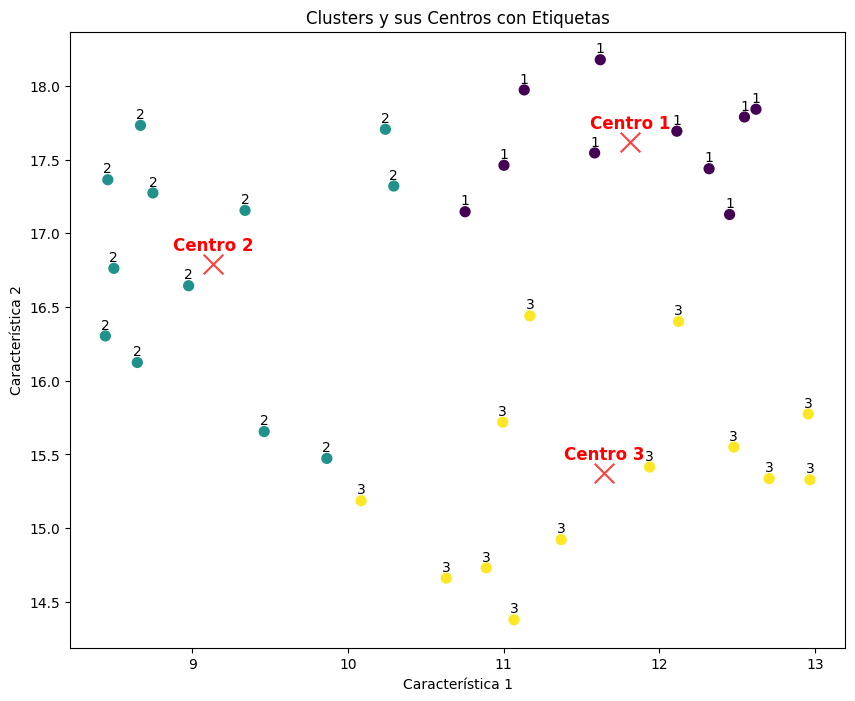

In [40]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus Centros con Etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

In [41]:
print(len(texts))
print(len(global_embeddings_reduced))

35
35


In [42]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()

,Texto,Embedding,Cluster
0,Depósito legal ppi 201502ZU4662 Esta publicaci...,"[10.294651, 17.32026]",2
1,Disponible en: https://produccioncientificaluz...,"[10.631482, 14.660879]",3
2,108Licencia de Creative Commons Atribución 4....,"[11.066402, 14.379072]",3
3,"la obtención de ganancias, siendo una condici...","[11.002208, 17.46104]",1
4,"109 Revista de Ciencias Sociales, Vol. XXIX, N...","[10.752725, 17.145983]",1


In [43]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{2: 'Depósito legal ppi 201502ZU4662 Esta publicación científica en formato digital es continuidad de la revista impresa Depósito Legal: pp 197402ZU789 ● ISSN: 1315-9518 ● ISSN-E: 2477-9431 Esta publicación científica en formato digital es continuidad de la revista impresa Depósito Legal: pp 197402ZU789 ISSN: 1315-9518Universidad del Zulia. Revista de la Facultad de Ciencias Económicas y Sociales Vol. XXIX, No. 4                                                    OCTUBRE-DICIEMBRE 2023 --- 119 Revista de Ciencias Sociales, Vol. XXIX, No. 4, 2023 octubre-diciembre ___________________________________________________________________107-124Licencia de Creative Commons  Atribución 4.0 Internacional (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/deed.es  categoría temática: La innovación, dificultó  realizar búsquedas y recuperación de datos  de forma eficaz, lo cual debilitó mostrar la  realidad sobre el avance y evolución de la  investigación.  Asimismo, se resaltan las debilidade

# Hay que volver a hacer un split de texto para solucionar problemas de capacidad en el LLM.

In [44]:
from langchain_core.output_parsers import StrOutputParser

template = """Eres Prometeo, un asistente capaz de crear resumenes detallados y concisos del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | turbo_llm | StrOutputParser()

In [45]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{2: 'La publicación científica en formato digital es una continuación de la revista impresa de la Universidad del Zulia. Se aborda la categoría temática de la innovación, destacando las dificultades en la realización de búsquedas y recuperación de datos de manera eficaz, así como las limitaciones en el análisis de contenido debido a la falta de acceso a software especializado. Se mencionan varias referencias bibliográficas relacionadas con la innovación en pequeñas y medianas empresas, abordando aspectos como la financiación, la gestión de la innovación, la cooperación empresarial y el impacto de la innovación en el desempeño de las empresas. Además, se destaca la importancia de la innovación abierta y se exploran diferentes factores que influyen en la capacidad innovadora de las pymes.',
 3: 'El artículo aborda la investigación de la innovación en pequeñas y medianas empresas (pymes) a nivel global, con un enfoque en las técnicas y enfoques cualitativos y cuantitativos utilizados en e

In [46]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{2: ['La publicación científica en formato digital es una continuación de la revista impresa de la Universidad del Zulia. Se aborda la categoría temática de la innovación, destacando las dificultades en la realización de búsquedas y recuperación de datos de manera eficaz, así como las limitaciones en el análisis de contenido debido a la falta de acceso a software especializado. Se mencionan varias referencias bibliográficas relacionadas con la innovación en pequeñas y medianas empresas, abordando aspectos como la financiación, la gestión de la innovación, la cooperación empresarial y el impacto de la innovación en el desempeño de las empresas. Además, se destaca la importancia de la innovación abierta y se exploran diferentes factores que influyen en la capacidad innovadora de las pymes.'],
 3: ['El artículo aborda la investigación de la innovación en pequeñas y medianas empresas (pymes) a nivel global, con un enfoque en las técnicas y enfoques cualitativos y cuantitativos utilizados e

In [47]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{2: 'La publicación científica digital de la Universidad del Zulia aborda la categoría temática de la innovación, resaltando las dificultades en la búsqueda y recuperación de datos, así como las limitaciones en el análisis de contenido por falta de acceso a software especializado. Se mencionan referencias bibliográficas sobre la innovación en pymes, incluyendo aspectos como financiación, gestión, cooperación empresarial e impacto en el desempeño. Se destaca la importancia de la innovación abierta y se exploran factores que influyen en la capacidad innovadora de las pymes.',
 3: 'En resumen, el artículo aborda la investigación de la innovación en pequeñas y medianas empresas a nivel global, con un enfoque en técnicas y enfoques cualitativos y cuantitativos. Se identificaron tendencias recientes a través del análisis de redes sociales y se destacó la importancia de la innovación tecnológica en las pymes, especialmente durante la pandemia de Covid-19. Se resalta la variedad de enfoques y 

In [48]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [49]:
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embeddings)

In [50]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuáles son las competencias del profesorado?", 10000, 4)
final_number

19

In [51]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [52]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de lectura que habla Español.

Tu tarea consiste en:

1. Ser carismático y ofrecer información sobre ti y tus funciones.

2. Leer detalladamente la información proporcionada en documentos
de texto en formato PDF, para ser capaz de dar respuestas a cualquier tipo de pregunta,
en especial a preguntas puntuales.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables del contexto.

Teniendo lo anterior en cuenta, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

In [53]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

¿Cuáles fueron los principales resultados de la investigación?
Los principales resultados de la investigación fueron la
identificación de tendencias en la innovación tecnológica en las
pequeñas y medianas empresas a nivel global, así como la importancia
de la gestión del conocimiento, la calidad de vida laboral, la gestión
del riesgo y la innovación abierta como factores clave para lograr
ventajas competitivas en las pymes.


In [54]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 30514 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

In [ ]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain.invoke(query)
wrapper = textwrap.TextWrapper(width=70) 
word_list = wrapper.wrap(text=llm_response) 

# Print each line. 
for element in word_list: 
    print(element)

### 2. Recordar (si y solo si Enseñar=Done)

In [ ]:
# Now we can load the persisted database from disk, and use it as normal. 
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)
retriever = vectordb.as_retriever(search_kwargs={"k": 5})
#retriever = vectordb.as_retriever()